# Results and plots

## Brute force approach

In [7]:
res = {"content": "rush_field_cuts_SDp","codec": "avc","width": 480,"height": 270,"fps": 29.97,"shots": [{"index": 0,"duration": 10.611,"assessment": {"crf": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,26,27,28,29,0,31,32,33,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"rate": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1254477,1085638,935833,801799,684622,0,492681,414777,347610,290466,242212,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"dist": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.985674,87.071674,84.816501,82.444409,79.70459,0.0,73.101066,69.42523,65.237103,60.838325,56.019107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]},"opt_points": [{"metric": "dist","target": 75,"crf": 32}]},{"index": 1,"duration": 2.003,"assessment": {"crf": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,26,27,28,29,0,31,32,33,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"rate": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1680954,1468153,1280938,1117715,973156,0,738751,640619,558218,480850,416163,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"dist": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.282299,96.994531,95.132537,92.543064,89.732716,0.0,83.433942,79.703344,75.78538,71.711082,67.100226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]},"opt_points": [{"metric": "dist","target": 75,"crf": 33}]},{"index": 2,"duration": 3.404,"assessment": {"crf": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,26,27,28,29,0,31,32,33,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"rate": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,916086,811727,716319,633882,561287,0,439649,388947,345212,306079,271121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"dist": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.019708,90.314922,88.277713,86.247534,83.721455,0.0,78.043433,74.8657,71.325387,67.802058,64.155059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]},"opt_points": [{"metric": "dist","target": 75,"crf": 29}]},{"index": 3,"duration": 3.004,"assessment": {"crf": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,26,27,28,29,0,31,32,33,34,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"rate": [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,729488,649978,578247,516487,459419,0,365965,324482,290346,258378,230154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"dist": [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,93.269671,91.412661,89.344999,87.1439,84.616461,0.0,78.855269,75.580998,72.044948,68.531343,64.507931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]},"opt_points": [{"metric": "dist","target": 75,"crf": 29}]}]}

In [17]:
import json
import numpy as np
import matplotlib.pyplot as pl

print(res["shots"][3]["assessment"]["rate"][29])

r1=np.array([414777,558218,561287,459419])
d1=np.array([69.42523,75.78538,83.721455,84.616461])
out_crfs= [32, 33, 29, 29]


459419


<Figure size 432x288 with 0 Axes>

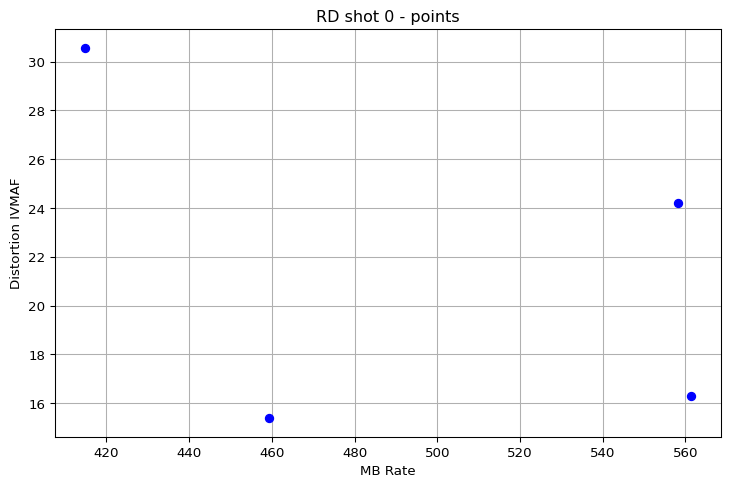

<Figure size 432x288 with 0 Axes>

In [18]:
my_dpi = 96
pl.figure(figsize=(860/my_dpi, 540/my_dpi), dpi=my_dpi)
pl.plot(r1/1000, 100-d1, 'bo')
#pl.plot([start[0],end[0]],[start[1],end[1]])
pl.grid(True)
pl.title("RD shot 0 - points")
pl.ylabel("Distortion IVMAF")
pl.xlabel("MB Rate")
pl.figure()

In [ ]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx
def log_fit(x, a, b, c):
    return a * np.log(x + b) + c

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
bitrates = []
vmafs = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "vp9"):
        bitrates.append(item["bitrate"])
        vmafs.append(item["vmaf"])
num_samples = (max(bitrates) - min(bitrates)) / 26

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, bitrates, vmafs, maxfev=2000)
xnew = np.arange(min(bitrates), max(bitrates)+num_samples, num_samples)
interp_vmaf = log_fit(xnew, *popt)

#SELECT TARGET
target_bitrate = 12000000
target_vmaf = 98
opt_dist = True
if(opt_dist):
    crf = find_closest(interp_vmaf, target_vmaf)
else:
    crf = find_closest(xnew, target_bitrate)
print(crf + 15)

In [ ]:
import matplotlib.pyplot as pl

pl.plot(bitrates, vmafs, 'bo')
pl.plot(xnew, interp_vmaf, 'r')
pl.grid(True)

#TODO: covariance testing, MSE assessment

The same but with RD:

In [ ]:
import json
import numpy as np
from scipy.optimize import curve_fit

def find_closest(arr, val):
    idx = (np.abs(arr - val)).argmin()
    return idx

def log_fit(x, a, b, c): #anche polinomio 2 grado
    return a * np.log(x + b) + c      

source = "forest"
filepath = "rd_results/rd_" + source + ".json"
rates = []
dists = []

with open(filepath, 'r') as r:
    i_data = json.load(r)
for item in i_data:
    if(item["codec"] == "hevc"):
        rates.append(item["bitrate"])
        dists.append(100 - item["vmaf"])
num_samples = (max(rates) - min(rates)) / 25 #to change

target_rate = 12000000
target_dist = 100 - 80
opt_dist = True

#LOG CURVE FITTING
popt, pcov = curve_fit(log_fit, rates, dists, maxfev=1000)
xrate = np.arange(min(rates), max(rates) + num_samples, num_samples)
ydist = np.asarray(log_fit(xrate, *popt))
if(opt_dist):
    crf = find_closest(ydist, target_dist)
else:
    crf = find_closest(xrate, target_rate)
print(crf + 15) #to change

In [ ]:
import matplotlib.pyplot as pl

pl.plot(rates, dists, 'bo')
pl.plot(xrate, ydist, 'r')
pl.grid(True)

In [ ]:
#NORMALIZATION
rates = np.asarray(rates)
dists = np.asarray(dists)
nx = (xrate - min(xrate))/(max(xrate) - min(xrate))
ny = (ydist - min(ydist))/(max(ydist) - min(ydist))
#npopt, npcov = curve_fit(log_fit, nx, ny, maxfev=1000)
#num_samples = 1 / 25 #to change
#nxrate = np.arange(min(nx), max(nx) + num_samples, num_samples)
#nydist = np.asarray(log_fit(nxrate, *popt))
ncrf = np.argmin(np.sqrt(np.add(nx**2, ny**2))) 
print(ncrf + 15)

In [ ]:
import matplotlib.pyplot as pl

x1 = nx[ncrf]
y1 = ny[ncrf]
pl.plot(x1, y1, 'go')
pl.plot(nx, ny, 'r')
pl.grid(True)

5


<Figure size 432x288 with 0 Axes>

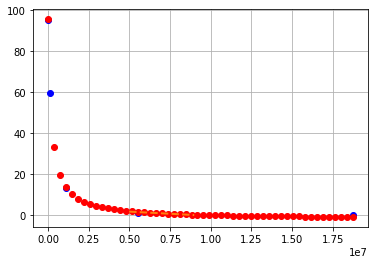

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as pl

def density_space(xs, ps, n, endpoint=False, order=1):
    from scipy.interpolate import interp1d
    from scipy.integrate import cumtrapz
    
    cps = cumtrapz(ps, xs, initial=0)
    cps *= (1/cps[-1])
    intfunc = interp1d(cps, xs, kind=order)
    return intfunc(np.linspace(0, 1, n, endpoint=endpoint))

def compute_slope(xl,yl,xr,yr):
    return -(yl-yr)/(xl-xr)
def eq_fit(x, a, b, c):
    #return a * np.log(x + b) + c
    #return a*x**2 + b*x + c
    #return c + (a / np.log2(x + b))
    return a / (x + b) + c
def as_slope(x, a):
    return a / (x ** 2)
def line(x, x1, y1):
    return -as_slope(x1, par[0])*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-2000000, x1+2000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)

crf = [0, 13, 26, 38, 51]
rates = [18729544, 5554671, 1085638, 138604, 12974]
dists = [8.0860000e-03, 1.0444440e+00, 1.2928326e+01, 5.9431145e+01, 9.5521998e+01]
par, cov = curve_fit(eq_fit, rates, dists)
num_samples = (max(rates) - min(rates)) / 51 #to change
xnew = np.arange(min(rates), max(rates)+num_samples, num_samples)
#xnew = density_space(rates,eq_fit(rates, *par),n=52, endpoint=True)
fun_curve = eq_fit(xnew, *par)
t_ext = compute_slope(rates[4],dists[4],rates[0],dists[0])
#print("t-slope: "+str("%.16f" % t_ext["slope"]))
#print(t_ext)

print(np.argmin(abs(t_ext-(par[0]/np.einsum('i,i->i',xnew,xnew)))))
#pl.plot(xnew1,fun_curve)
pl.plot(rates, dists, 'bo')
pl.plot(xnew, fun_curve, 'ro')
show_tangent(xnew[19],fun_curve[19])
pl.grid(True)
pl.figure()


In [3]:
import matplotlib.pyplot as pl

def slope(x):
    return popt[0] / (x + popt[1])
def line(x, x1, y1):
    return slope(x1)*(x - x1) + y1
def show_tangent(x1,y1):
    # Define x data range for tangent line
    xrange = np.linspace(x1-50000000, x1+50000000, 2)
    pl.plot(xrange, line(xrange, x1, y1), 'C1--', linewidth = 2)

x1 = xrate[crf]
y1 = ydist[crf]

pl.plot(x1, y1, 'go')
pl.plot(xrate, ydist, 'r')
show_tangent(x1,y1)
pl.grid(True)

#TODO: linear inverse testing

NameError: name 'xrate' is not defined